# 足球战术可视化
### 任务：根据上赛季若干场红蓝两队交战数据，分析双方战术优势与短板，并为红队不久将来与蓝队的交战提出建议。
### 输入数据：上赛季的4场联赛数据和1场杯赛数据，在每一时间点（间隔为0.2秒）下所有球员、足球的坐标数据，以及该时刻持球者的编号。
####  
对于这一问题，我的想法较多，如绘制热力图，分析传接球次数等。首先引入必要的包，以便接下来的分析。

In [1]:
import pandas as pd
import cv2
import math
import numpy as npy
from PIL import Image
from pyheatmap.heatmap import HeatMap
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams['font.sans-serif']=['SimHei']

## Step 1 — 读入数据，获取交战比分
####  
由于数据特性，进球有效后足球会被放置在坐标(0, 0, 0)处，我们只需要统计球被放置在该坐标处的次数，以及持球人所在的队伍，即可得到交战比分。

In [2]:
N = 6

datas = [None for _ in range(N)]

for i in range(N):
    r_score, b_score = 0, 0
    datas[i] = pd.read_csv("./data/timeRecord%d.csv"%(i))
    
    sl = []
    for j in range(1, datas[i].shape[0]):
        sf1 = datas[i].loc[j - 1, '足球']
        sf2 = datas[i].loc[j, '足球']
        sr = datas[i].loc[j, '红方持球者']
        sb = datas[i].loc[j, '蓝方持球者']
        if(sf1 != '0 0 0' and sf2 == '0 0 0'):
            if(int(sr) == -1 and int(sb) != -1):
                r_score += 1
                sl.append('红')
            elif(int(sr) != -1 and int(sb) == -1):
                b_score += 1
                sl.append('蓝')
        
    print("%d:%d"%(r_score, b_score), sl)

3:2 ['红', '红', '红', '蓝', '蓝']
2:2 ['红', '蓝', '红', '蓝']
1:2 ['蓝', '蓝', '红']
0:1 ['蓝']
1:3 ['蓝', '蓝', '红', '蓝']
1:0 ['红']


四场联赛1胜1平2负，杯赛第一场1:3败北，第二场虽1:0点球绝杀获胜，但没能改变被淘汰的命运。

可以看出，红队先手进球时，结果往往是红胜或平局；而蓝队先手进球后，红队的士气会受到影响。因此**红队擅长踢顺风球，拿下先手进球权十分重要**。
####  
接下来我们来观察数据的结构。

In [3]:
data = pd.concat(datas, ignore_index=True)

data.head(data.shape[0])

,时间,红方0,红方1,红方2,红方3,红方4,红方5,红方6,红方7,红方8,...,蓝方4,蓝方5,蓝方6,蓝方7,蓝方8,蓝方9,蓝方10,足球,红方持球者,蓝方持球者
0,"00'00""00",50 0,120 -320,120 320,225 0,300 -80,350 80,450 -300,450 300,500 -120,...,-250 -120,-300 0,-450 300,-450 -300,-500 120,-500 -120,-680 0,0 2 0,0,-1
1,"00'00""12",31 0,103 -321,101 321,210 1,286 -84,335 79,434 -302,435 302,485 -118,...,-255 -106,-314 0,-441 288,-440 -287,-491 111,-490 -110,-681 0,0 2 0,0,-1
2,"00'00""24",9 0,83 -321,80 321,193 2,271 -88,318 78,416 -305,417 305,468 -116,...,-260 -90,-330 0,-429 274,-427 -272,-479 101,-477 -99,-681 0,0 2 0,0,-1
3,"00'00""36",-1 0,66 -321,61 322,178 2,257 -92,302 81,399 -307,401 307,453 -114,...,-265 -75,-343 0,-419 262,-415 -259,-468 93,-464 -91,-685 0,0 2 0,0,-1
4,"00'00""48",-3 1,53 -311,42 321,163 3,244 -96,287 84,383 -307,385 309,437 -115,...,-270 -61,-355 -2,-408 250,-403 -247,-463 88,-462 -94,-681 -7,-1 26 -30,1,-1
5,"00'01""00",-21 1,44 -297,24 317,149 3,231 -97,272 85,367 -301,370 304,422 -114,...,-270 -66,-360 -13,-398 237,-388 -245,-470 83,-465 -106,-684 -20,-1 22 -63,1,-1
6,"00'01""12",-40 2,34 -283,6 313,136 2,218 -98,257 83,351 -298,356 297,407 -114,...,-266 -80,-355 -26,-391 223,-386 -258,-469 75,-455 -110,-683 -33,-1 12 -96,1,-1
7,"00'01""24",-58 3,25 -268,-10 318,123 0,205 -102,242 80,335 -300,343 289,393 -117,...,-264 -95,-349 -39,-389 211,-395 -262,-465 71,-450 -121,-683 -46,-1 2 -127,1,-1
8,"00'01""36",-76 4,17 -253,-29 322,110 -5,192 -106,227 77,319 -303,329 280,379 -120,...,-265 -110,-343 -52,-392 210,-388 -263,-471 66,-458 -132,-683 -59,-1 6 -153,1,-1
9,"00'01""48",-95 5,10 -238,-47 323,96 -6,180 -110,213 73,303 -307,315 272,366 -124,...,-266 -125,-339 -65,-391 206,-384 -272,-469 62,-462 -138,-683 -72,-1 5 -178,1,-1


可以看到球员位置的坐标是二维的，而足球的坐标是三维的。
####  
下一步我们可以可视化球员与足球运动的热力图与站位的点击图。首先写出热力图与点击图可视化的函数。

In [4]:
def apply_heatmap(image, data, r):
    #background = Image.new("RGB", (image.shape[1], image.shape[0]), color=(127, 127, 127))
    
    hm = HeatMap(data)
    hit_img = hm.heatmap(base=Image.fromarray(image.astype('uint8')).convert('RGB'), r=r)
    hit_img = cv2.cvtColor(npy.asarray(hit_img), cv2.COLOR_RGB2BGR)
    
    return cv2.addWeighted(hit_img, 0.8, image, 0.2, 0)

def apply_clickmap(image, data):
    #background = Image.new("RGB", (image.shape[1], image.shape[0]), color=(127, 127, 127))
    
    hm = HeatMap(data)
    hit_img = hm.clickmap(base=Image.fromarray(image.astype('uint8')).convert('RGB'), color=(191, 191, 255))
    hit_img = cv2.cvtColor(npy.asarray(hit_img), cv2.COLOR_RGB2BGR)
    
    return hit_img

## Step 2 — 判断球员位置
根据球员活动区域与行为，大致可以将球员分为以下10类：
* 中锋
* （左/右）边锋
* 影锋
* 前腰
* （左/右）边前卫
* 中前卫
* 后腰
* （左/右）边后卫
* 中后卫
* 守门员

利用热力图可视化其活动区域，可以大致判断球员的位置。

In [5]:
red_player_data = [None for _ in range(11)]
for i in range(11):
    red_player_data[i] = [[(int(s.split()[0]) + 800) // 5, (int(s.split()[1]) + 450) // 5] for s in data['红方%d'%(i)].values]
print(red_player_data[0][0:5])

blue_player_data = [None for _ in range(11)]
for i in range(11):
    blue_player_data[i] = [[(int(s.split()[0]) + 800) // 5, (int(s.split()[1]) + 450) // 5] for s in data['蓝方%d'%(i)].values]
print(blue_player_data[0][0:5])

[[170, 90], [166, 90], [161, 90], [159, 90], [159, 90]]
[[150, 106], [153, 105], [156, 106], [158, 109], [160, 110]]


接下来准备背景图，用于叠加到热力图中，方便观察。

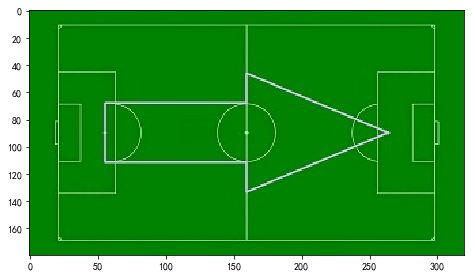

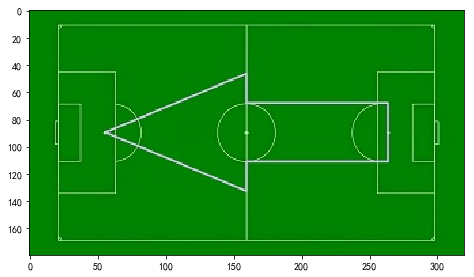

In [6]:
left_arrow = plt.imread('./imgs/left_arrow.jpg')
right_arrow = plt.imread('./imgs/right_arrow.jpg')

plt.figure(figsize=(8, 4.5))
plt.imshow(left_arrow)
plt.figure(figsize=(8, 4.5))
plt.imshow(right_arrow)

首先我们可视化红队11名球员的活动热力图。

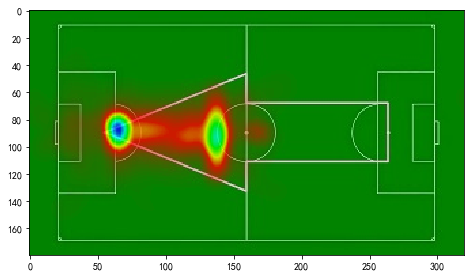

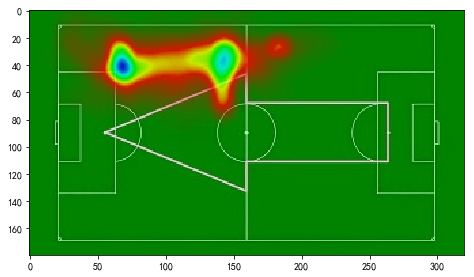

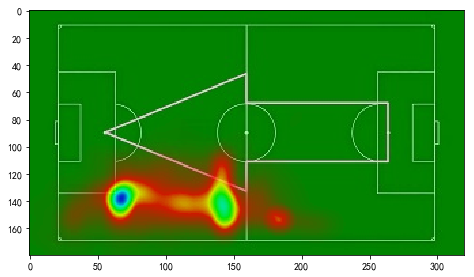

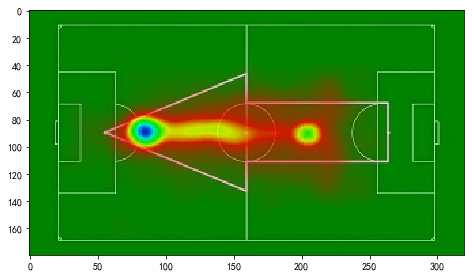

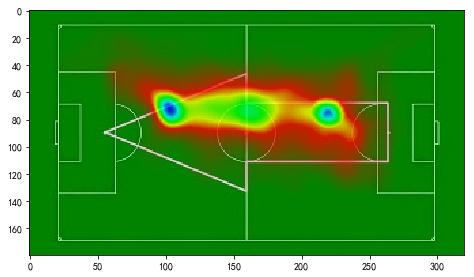

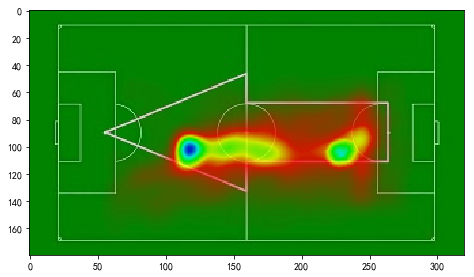

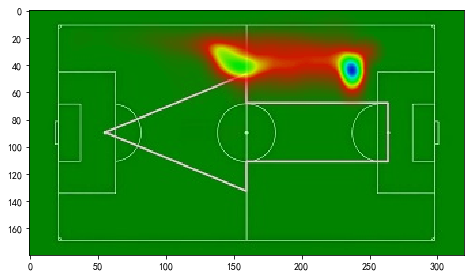

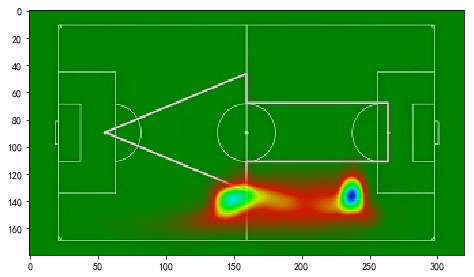

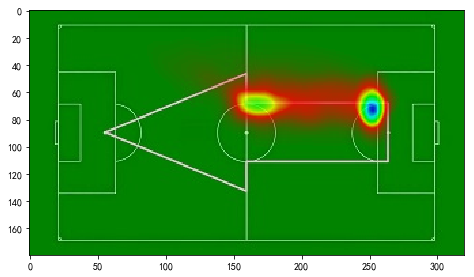

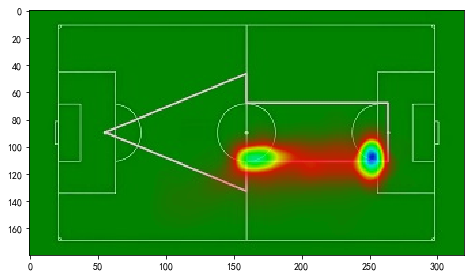

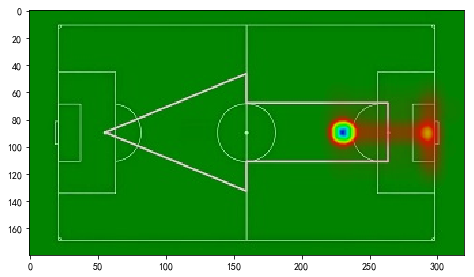

In [7]:
for i in range(11):
    plt.figure(figsize=(8, 4.5))
    plt.imshow(apply_heatmap(right_arrow, red_player_data[i], 12))

可以看到相对明显的4-3-3站位，0号为中锋，1、2号分别为左右边锋，3~5号为中场，6、7号为左右边后卫，8、9号为中后卫，10号为门将。

同样的，我们也可以可视化蓝队的球员活动区域。

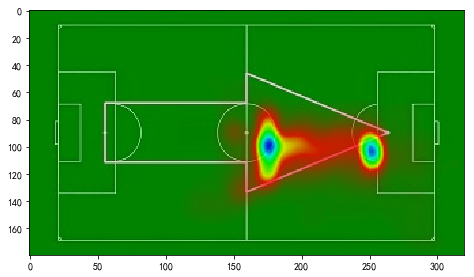

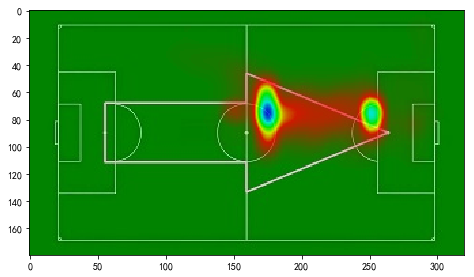

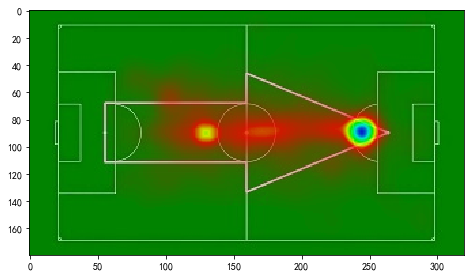

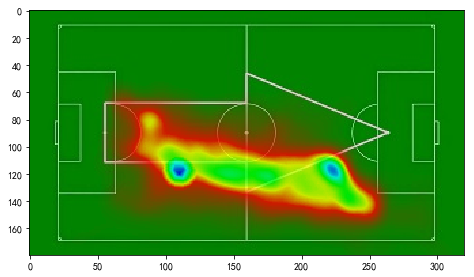

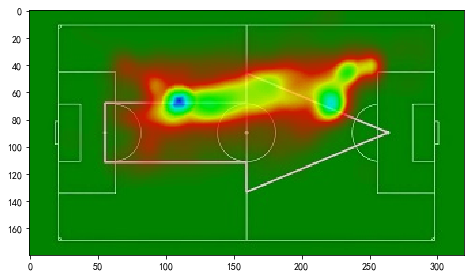

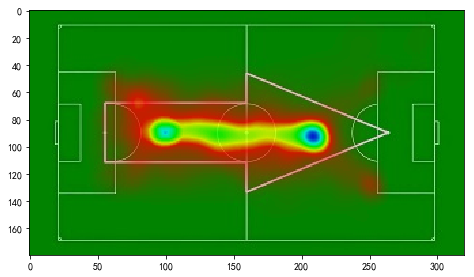

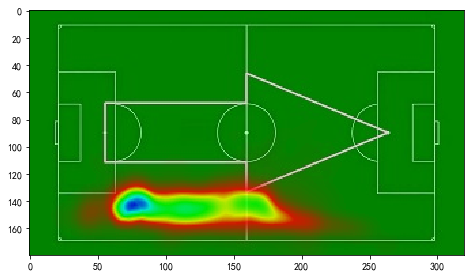

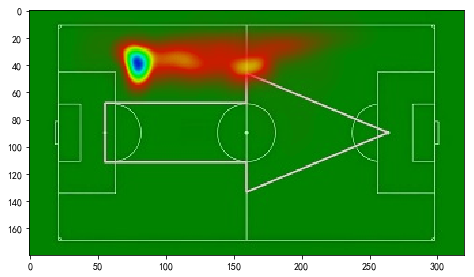

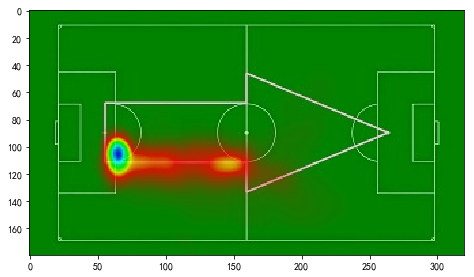

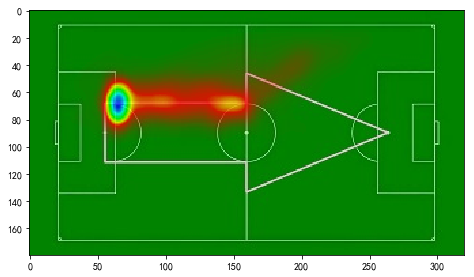

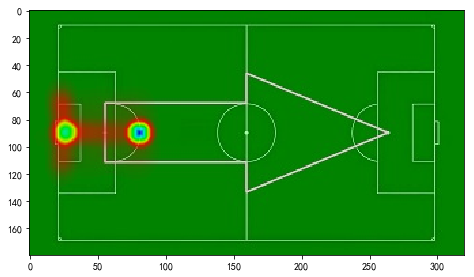

In [8]:
for i in range(11):
    plt.figure(figsize=(8, 4.5))
    plt.imshow(apply_heatmap(left_arrow, blue_player_data[i], 12))

根据热力图我们很难确定其站位。像是4-4-2的站位，但双中锋活动区域并没有深入对手防线；又像是4-2-3-1的站位，但影锋的回防未免太深了。可见蓝队的阵型布局更具迷惑性。

接下来我们绘制出比赛开始时所有球员的站位，来验证刚刚的猜想。

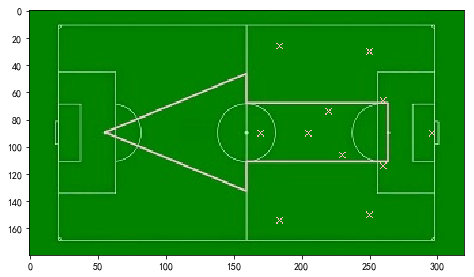

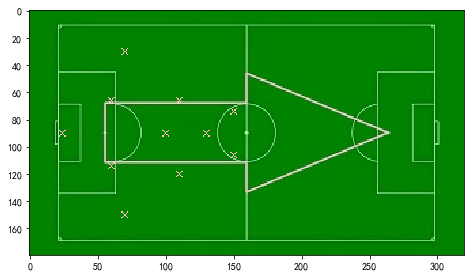

In [9]:
red_stand_posi = [red_player_data[i][0] for i in range(11)]
blue_stand_posi = [blue_player_data[i][0] for i in range(11)]

plt.figure(figsize=(8, 4.5))
plt.imshow(apply_clickmap(right_arrow, red_stand_posi))

plt.figure(figsize=(8, 4.5))
plt.imshow(apply_clickmap(left_arrow, blue_stand_posi))

从点击图中，可以看出红队确实是4-3-3，或者说是4-2-1-3站位的；而蓝队则是4-3-1-2站位。蓝队两前锋虽并不是完全的进攻球员，但活动区域较小且行为相似，因此都算作中锋；而前腰则更像影锋，活动区域较大；两个边后卫的行为也不尽相同，战术较红队变化更多。

## Step 3 — 交战区域
### 1. 进攻区域
可视化足球在红方、蓝方分别持有球权时的活动区域的热力图，以分析其进攻区域。

In [10]:
red_hand_ball_data = [[(int(s.split()[0]) + 800) // 5, (int(s.split()[2]) + 450) // 5]for s in data.loc[(data['红方持球者'] != -1) & (data['足球'] != '0 0 0'), '足球'].values]
blue_hand_ball_data = [[(int(s.split()[0]) + 800) // 5, (int(s.split()[2]) + 450) // 5]for s in data.loc[(data['蓝方持球者'] != -1) & (data['足球'] != '0 0 0'), '足球'].values]
ball_data = [[(int(s.split()[0]) + 800) // 5, (int(s.split()[2]) + 450) // 5]for s in data.loc[data['足球'] != '0 0 0', '足球'].values]

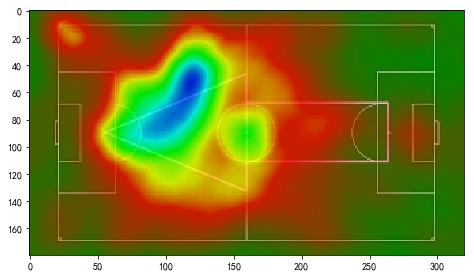

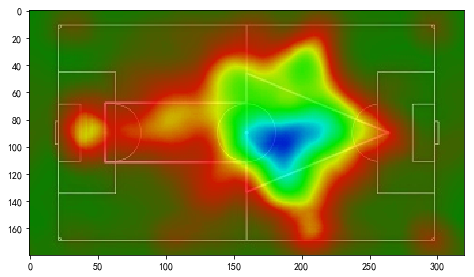

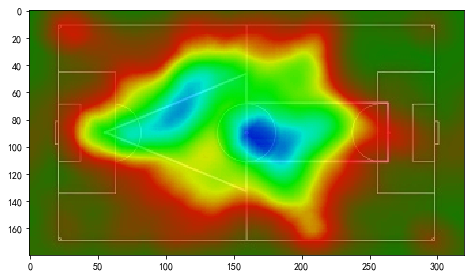

In [11]:
plt.figure(figsize=(8, 4.5))
plt.imshow(apply_heatmap(right_arrow, red_hand_ball_data, 24))

plt.figure(figsize=(8, 4.5))
plt.imshow(apply_heatmap(left_arrow, blue_hand_ball_data, 24))

plt.figure(figsize=(8, 4.5))
plt.imshow(apply_heatmap(right_arrow, ball_data, 24))

看得出，红队的进攻区域更加宽广，在边路配合流畅；而蓝队擅长边路佯攻，而进攻核心在中路。整体形势来看，红队目的性更弱一些，进攻战术以传控为主；而蓝队目的性更强一些，进攻战术更偏重于防守反击。

### 2. 进攻方式
由于数据中还含有足球的高度信息，我们可以根据这一信息来判断球队的进攻方式，即进攻组织为长传还是短传。对此我们可以绘制箱线图来解决。

In [12]:
red_hand_ball_height = [(int(s.split()[1])) // 5 for s in data.loc[(data['红方持球者'] != -1) & (data['足球'] != '0 0 0'), '足球'].values]
blue_hand_ball_height = [(int(s.split()[1])) // 5 for s in data.loc[(data['蓝方持球者'] != -1) & (data['足球'] != '0 0 0'), '足球'].values]
ball_height = [(int(s.split()[1])) // 5 for s in data.loc[data['足球'] != '0 0 0', '足球'].values]

Text(0.5, 1.0, '红/蓝方球队传球时球高箱线图')

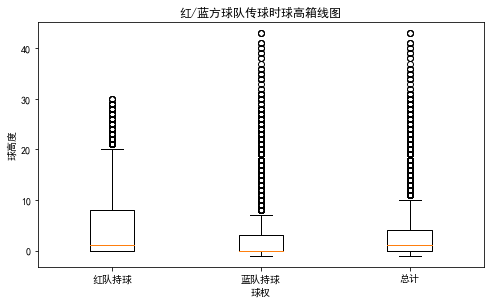

In [13]:
plt.figure(figsize=(8, 4.5))
plt.boxplot((red_hand_ball_height, blue_hand_ball_height, ball_height), labels=('红队持球', '蓝队持球', '总计'))
plt.xlabel("球权")
plt.ylabel("球高度")
plt.title("红/蓝方球队传球时球高箱线图")

可以看出红队是稳定的高空球战术，而蓝队则更加重视地面球，除少数长传外，极少传递高空球。

### 3. 防守区域
通过热力图可视化抢断、拦截传球的位置，来判断球队在哪些区域布有重兵防守。

In [14]:
red_steal = []

for i in range(1, data.shape[0]):
    if((data.loc[i - 1, '红方持球者'] == -1) and (data.loc[i, '红方持球者'] != -1)):
        ball_posi = data.loc[i, '足球'].split()
        red_steal.append([(int(ball_posi[0]) + 800) // 5, (int(ball_posi[2]) + 450) // 5])

blue_steal = []

for i in range(1, data.shape[0]):
    if((data.loc[i - 1, '蓝方持球者'] == -1) and (data.loc[i, '蓝方持球者'] != -1)):
        ball_posi = data.loc[i, '足球'].split()
        blue_steal.append([(int(ball_posi[0]) + 800) // 5, (int(ball_posi[2]) + 450) // 5])

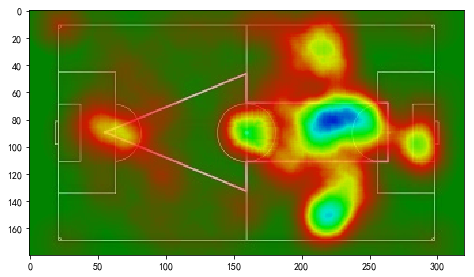

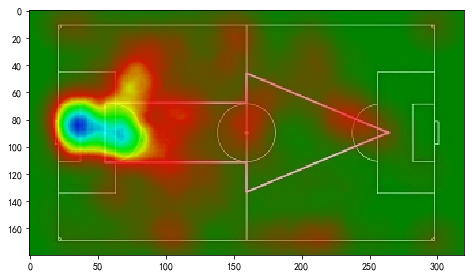

In [15]:
plt.figure(figsize=(8, 4.5))
plt.imshow(apply_heatmap(right_arrow, red_steal, 24))

plt.figure(figsize=(8, 4.5))
plt.imshow(apply_heatmap(left_arrow, blue_steal, 24))

可以看出，两队重兵把守区域与进攻区域相似。红队在边路的抢断更多一些，蓝队则在中路的抢断更多一些。除此之外，我们发现，红队擅长前线施压夺球，而蓝队则更偏重于全攻全守。结合球员跑动热力图，我们证实了此前分析得到的结论——蓝队的战术可以概括为12字，**请君入瓮，瓮中捉鳖，快速反击**。

## Step 4 — 球员个人能力分析

除去分析球队战术外，我们还可以分析球员的个人能力。

In [16]:
tlabel = [("红%d"%(i + 1))for i in range(11)] + [("蓝%d"%(i + 1))for i in range(11)] + ['红均', '蓝均']
tcolor = ["r" for _ in range(11)] + ["b" for _ in range(11)] + ['salmon', 'lightskyblue']

首先我们可以分析每个球员被抢断、主动抢断和触球的次数，并绘制条形图。

In [17]:
red_lose_cnt = [0 for _ in range(11)]
blue_lose_cnt = [0 for _ in range(11)]

red_get_cnt = [0 for _ in range(11)]
blue_get_cnt = [0 for _ in range(11)]

red_touch_cnt = [0 for _ in range(11)]
blue_touch_cnt = [0 for _ in range(11)]

for i in range(1, data.shape[0]):
    if((data.loc[i - 1, '红方持球者'] != -1) and (data.loc[i, '蓝方持球者'] != -1)):
        red_lose_cnt[int(data.loc[i - 1, '红方持球者'])] += 1
        blue_get_cnt[int(data.loc[i, '蓝方持球者'])] += 1
    elif((data.loc[i - 1, '蓝方持球者'] != -1) and (data.loc[i, '红方持球者'] != -1)):
        blue_lose_cnt[int(data.loc[i - 1, '蓝方持球者'])] += 1
        red_get_cnt[int(data.loc[i, '红方持球者'])] += 1
    
    if((data.loc[i - 1, '红方持球者'] != data.loc[i, '红方持球者']) and (data.loc[i, '红方持球者'] != -1)):
        red_touch_cnt[int(data.loc[i, '红方持球者'])] += 1
        
    if((data.loc[i - 1, '蓝方持球者'] != data.loc[i, '蓝方持球者']) and (data.loc[i, '蓝方持球者'] != -1)):
        blue_touch_cnt[int(data.loc[i, '蓝方持球者'])] += 1

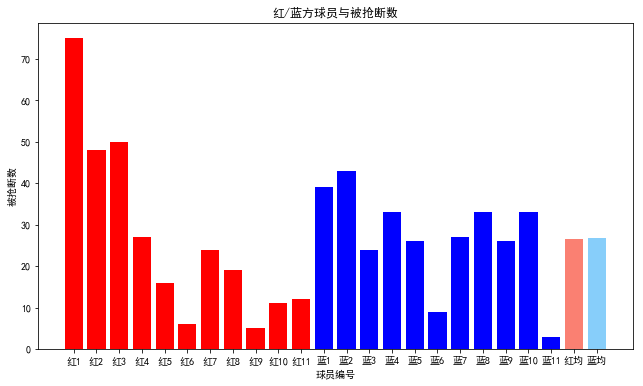

In [18]:
plt.figure(figsize=(32/3, 6))
plt.bar(range(24), red_lose_cnt + blue_lose_cnt + [npy.mean(red_lose_cnt), npy.mean(blue_lose_cnt)], color=tcolor, tick_label=tlabel)
plt.xlabel("球员编号")
plt.ylabel("被抢断数")
plt.title("红/蓝方球员与被抢断数")
plt.show()

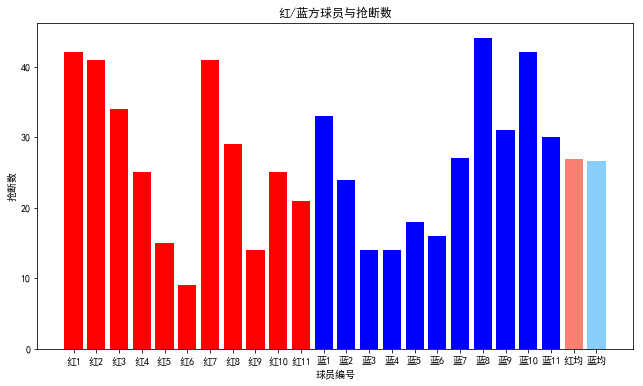

In [19]:
plt.figure(figsize=(32/3, 6))
plt.bar(range(24), red_get_cnt + blue_get_cnt + [npy.mean(red_get_cnt), npy.mean(blue_get_cnt)], color=tcolor, tick_label=tlabel)
plt.xlabel("球员编号")
plt.ylabel("抢断数")
plt.title("红/蓝方球员与抢断数")
plt.show()

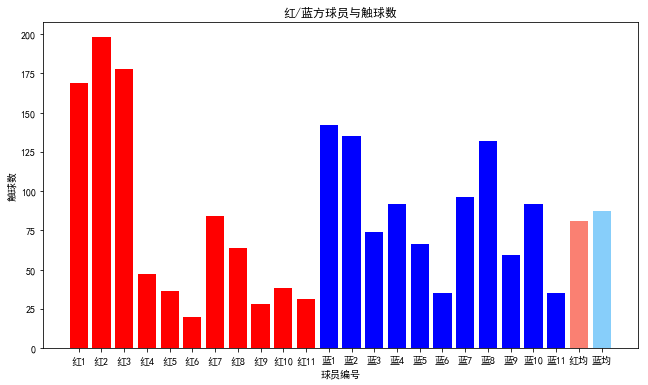

In [20]:
plt.figure(figsize=(32/3, 6))
plt.bar(range(24), red_touch_cnt + blue_touch_cnt + [npy.mean(red_touch_cnt), npy.mean(blue_touch_cnt)], color=tcolor, tick_label=tlabel)
plt.xlabel("球员编号")
plt.ylabel("触球数")
plt.title("红/蓝方球员与触球数")
plt.show()

可以看出，红方9号和红方8号虽然同为边后卫，在热力图中跑动区域也相似，但9号更少参与进攻与防守。而红方后腰7号则为红队防守核心人物。

由于红方战术要求球员更多地就地反抢，造成了前锋拥有较多的抢断数。

而红方三前锋更是进攻核心球员，从热力图中也可以看出，他们回撤到中圈接球，然后在中前场打出配合，进而创造出机会。而蓝方的配合则更加平均。

概括一下红蓝两方的战术：
* **红方：分工明晰，配合默契。**
* **蓝方：全民皆兵，防守反击。**

## 除此之外做过的其它尝试

除上述分析外，我还尝试过利用其它信息进行分析，如跑动距离、控球率等。

In [21]:
red_run_dist = [0 for _ in range(11)]
blue_run_dist = [0 for _ in range(11)]

for i in range(1, data.shape[0]):
    for j in range(11):
        posi1 = npy.array([int(p) for p in data.loc[i - 1, '红方%d'%(j)].split()])
        posi2 = npy.array([int(p) for p in data.loc[i, '红方%d'%(j)].split()])
        
        red_run_dist[j] += npy.linalg.norm(posi2 - posi1)
        
    for j in range(11):
        posi1 = npy.array([int(p) for p in data.loc[i - 1, '蓝方%d'%(j)].split()])
        posi2 = npy.array([int(p) for p in data.loc[i, '蓝方%d'%(j)].split()])
        
        blue_run_dist[j] += npy.linalg.norm(posi2 - posi1)

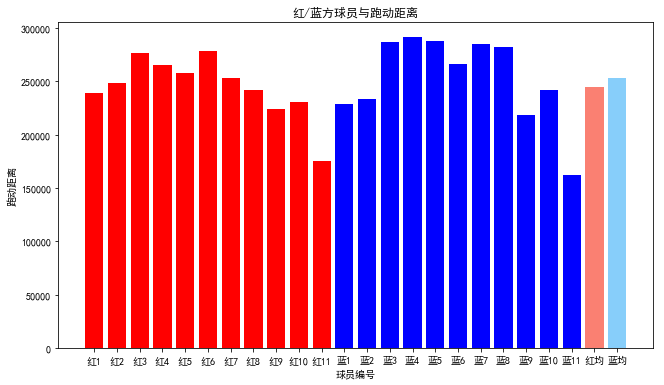

In [22]:
plt.figure(figsize=(32/3, 6))
plt.bar(range(24), red_run_dist + blue_run_dist + [npy.mean(red_run_dist), npy.mean(blue_run_dist)],
        color=tcolor, tick_label=tlabel)
plt.xlabel("球员编号")
plt.ylabel("跑动距离")
plt.title("红/蓝方球员与跑动距离")
plt.show()

In [23]:
red_hand_time_cnt = data[data['红方持球者'] != -1].count()['足球']
blue_hand_time_cnt = data[data['蓝方持球者'] != -1].count()['足球']
total_hand_time_cnt = data[(data['红方持球者'] != -1) | (data['蓝方持球者'] != -1)].count()['足球']


print('红方控球率：%.2f%%'%(red_hand_time_cnt / total_hand_time_cnt * 100))
print('蓝方控球率：%.2f%%'%(blue_hand_time_cnt / total_hand_time_cnt * 100))

红方控球率：48.43%
蓝方控球率：51.57%


# 球员行为预测模型

有了这些数据，我们可以分析的绝对不止是以上信息。比如我们还可以建立统计模型，预测球员的行为，完成类似于“球赛模拟器”的软件。

## 传球预测

假设球员的传球仅仅受持球球员的位置、目标球员的位置、球员间的距离、对方球员与传球路线的距离四个因素影响。

比如我们可以可视化所有发生传球行为时持球球员与目标球员间距离的分布情况。

In [24]:
pass_dist = []

for i in range(1, data.shape[0]):
    hand_pre = int(data.loc[i - 1, '红方持球者'])
    hand_pre_team = '红方'
    if(hand_pre == -1):
        hand_pre = int(data.loc[i - 1, '蓝方持球者'])
        hand_pre_team = '蓝方'
    if(hand_pre == -1):
        continue
    
    hand_cur = int(data.loc[i, '红方持球者'])
    hand_cur_team = '红方'
    if(hand_cur == -1):
        hand_cur = int(data.loc[i, '蓝方持球者'])
        hand_cur_team = '蓝方'
    if(hand_cur == -1):
        continue
    
    ball_posi_pre = npy.array([int(t) for t in data.loc[i - 1, '足球'].split()])
    ball_posi_cur = npy.array([int(t) for t in data.loc[i, '足球'].split()])
    
    if(hand_pre == hand_cur or hand_pre_team != hand_cur_team or npy.linalg.norm(ball_posi_cur - ball_posi_pre) > 100):
        continue
    
    hand_pre_posi = npy.array([int(t) for t in data.loc[i - 1, hand_pre_team + str(hand_pre)].split()])
    hand_cur_posi = npy.array([int(t) for t in data.loc[i, hand_cur_team + str(hand_cur)].split()])
    
    pass_dist.append(npy.linalg.norm(hand_cur_posi - hand_pre_posi))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


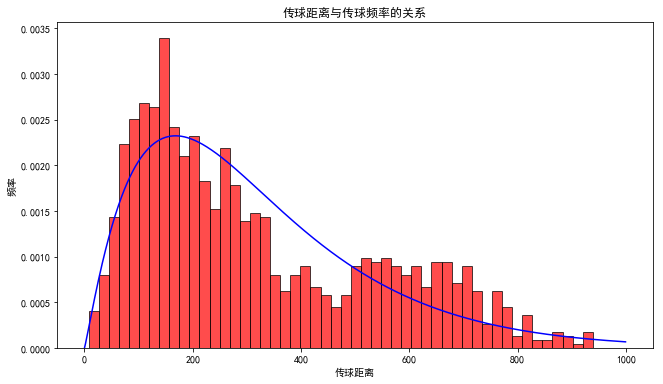

α=2.110576, β=0.006605


In [25]:
plt.figure(figsize=(32/3, 6))
plt.hist(pass_dist, bins=50, normed=1, facecolor="red", edgecolor="black", alpha=0.7)

mu_1 = npy.mean(pass_dist)
mu_2 = npy.var(pass_dist)

ga_alpha = mu_1 * mu_1 / mu_2
ga_beta = mu_1 / mu_2
plt.plot(range(1000),
         [((ga_beta ** ga_alpha) / math.gamma(ga_alpha) * (i ** (ga_alpha - 1)) * math.exp(-ga_beta * i)) for i in range(1000)],
         color="blue")
plt.xlabel("传球距离")
plt.ylabel("频率")
plt.title("传球距离与传球频率的关系")
plt.show()

print("α=%f, β=%f"%(ga_alpha, ga_beta))

可以看出，上图平滑曲线是一个偏态分布——可以认为传球距离服从α> 1的伽马分布。
<img src=".\imgs\gamma.png" width=288px height=416px/>
接下来我们可视化传球发生时对方球员位置的分布情况。

In [26]:
enemy_dist = []

for i in range(1, data.shape[0]):
    hand_pre = int(data.loc[i - 1, '红方持球者'])
    hand_pre_team = '红方'
    if(hand_pre == -1):
        hand_pre = int(data.loc[i - 1, '蓝方持球者'])
        hand_pre_team = '蓝方'
    if(hand_pre == -1):
        continue
    
    hand_cur = int(data.loc[i, '红方持球者'])
    hand_cur_team = '红方'
    if(hand_cur == -1):
        hand_cur = int(data.loc[i, '蓝方持球者'])
        hand_cur_team = '蓝方'
    if(hand_cur == -1):
        continue
    
    ball_posi_pre = npy.array([int(t) for t in data.loc[i - 1, '足球'].split()])
    ball_posi_cur = npy.array([int(t) for t in data.loc[i, '足球'].split()])
    
    if(hand_pre == hand_cur or hand_pre_team != hand_cur_team or npy.linalg.norm(ball_posi_cur - ball_posi_pre) > 100):
        continue
    
    enemy_team = '红方' if hand_cur_team == '蓝方' else '蓝方'
    
    ball_posi_cur = npy.array([ball_posi_cur[0], ball_posi_cur[2]])
    
    enemy_pre_posi = npy.array([int(t) for t in data.loc[i - 1, enemy_team + "0"].split()])
    enemy_dist.append(npy.linalg.norm(ball_posi_cur - enemy_pre_posi))
    for j in range(1, 11):
        enemy_pre_posi = npy.array([int(t) for t in data.loc[i - 1, enemy_team + str(j)].split()])

        enemy_dist[-1] = min(npy.linalg.norm(ball_posi_cur - enemy_pre_posi), enemy_dist[-1])

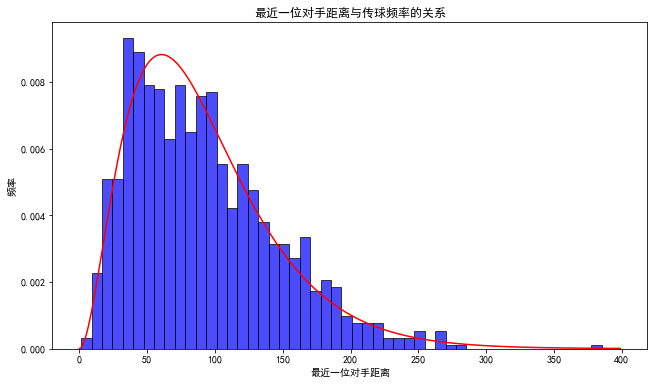

α=2.961396, β=0.032346


In [27]:
plt.figure(figsize=(32/3, 6))
plt.hist(enemy_dist, bins=50, normed=1, facecolor="blue", edgecolor="black", alpha=0.7)

mu_1 = npy.mean(enemy_dist)
mu_2 = npy.var(enemy_dist)

ga_alpha = mu_1 * mu_1 / mu_2
ga_beta = mu_1 / mu_2
plt.plot(range(400),
         [((ga_beta ** ga_alpha) / math.gamma(ga_alpha) * (i ** (ga_alpha - 1)) * math.exp(-ga_beta * i)) for i in range(400)],
         color="red")

plt.xlabel("最近一位对手距离")
plt.ylabel("频率")
plt.title("最近一位对手距离与传球频率的关系")
plt.show()
print("α=%f, β=%f"%(ga_alpha, ga_beta))

同样可以认为最近一位对手的距离近似服从伽马分布。

## 盘带预测

假设球员的盘带仅仅受持球球员的位置、对方球员位置和队友球员位置三个因素影响。

比如我们可以可视化所有发生盘带行为时盘带距离的分布情况。

In [28]:
dribble_dist = [0]

for i in range(1, data.shape[0]):
    hand_pre = int(data.loc[i - 1, '红方持球者'])
    hand_pre_team = '红方'
    if(hand_pre == -1):
        hand_pre = int(data.loc[i - 1, '蓝方持球者'])
        hand_pre_team = '蓝方'
    if(hand_pre == -1):
        if dribble_dist[-1] != 0:
            dribble_dist.append(0)
        continue
    
    hand_cur = int(data.loc[i, '红方持球者'])
    hand_cur_team = '红方'
    if(hand_cur == -1):
        hand_cur = int(data.loc[i, '蓝方持球者'])
        hand_cur_team = '蓝方'
    if(hand_cur == -1):
        if dribble_dist[-1] != 0:
            dribble_dist.append(0)
        continue
    
    ball_posi_pre = npy.array([int(t) for t in data.loc[i - 1, '足球'].split()])
    ball_posi_cur = npy.array([int(t) for t in data.loc[i, '足球'].split()])
    
    hand_posi_pre = [int(t) for t in data.loc[i - 1, hand_pre_team + str(hand_pre)].split()]
    hand_posi_cur = [int(t) for t in data.loc[i, hand_cur_team + str(hand_cur)].split()]
    
    hand_posi_pre = npy.array([hand_posi_pre[0], 2, hand_posi_pre[1]])
    hand_posi_cur = npy.array([hand_posi_cur[0], 2, hand_posi_cur[1]])
    
    if(hand_pre != hand_cur or hand_pre_team != hand_cur_team or npy.linalg.norm(ball_posi_cur - ball_posi_pre) > 100 or npy.linalg.norm(ball_posi_cur - hand_posi_cur) > 100):
        if dribble_dist[-1] != 0:
            dribble_dist.append(0)
        continue

    dribble_dist[-1] += npy.linalg.norm(hand_posi_cur - hand_posi_pre)

if(dribble_dist[-1] == 0):
    dribble_dist.pop(-1)

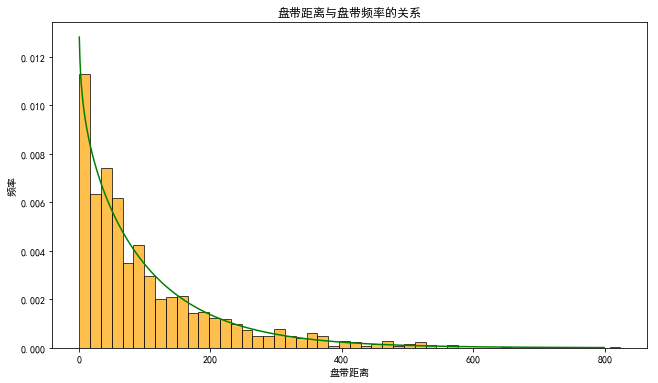

α=0.900140, β=0.008590


In [29]:
plt.figure(figsize=(32/3, 6))
plt.hist(dribble_dist, bins=50, normed=1, facecolor="orange", edgecolor="black", alpha=0.7)

mu_1 = npy.mean(dribble_dist)
mu_2 = npy.var(dribble_dist)

ga_alpha = mu_1 * mu_1 / mu_2
ga_beta = mu_1 / mu_2
plt.plot(range(1,800),
         [((ga_beta ** ga_alpha) / math.gamma(ga_alpha) * (i ** (ga_alpha - 1)) * math.exp(-ga_beta * i)) for i in range(1,800)],
         color="green")

plt.xlabel("盘带距离")
plt.ylabel("频率")
plt.title("盘带距离与盘带频率的关系")
plt.show()
print("α=%f, β=%f"%(ga_alpha, ga_beta))

#### 有了这些分布，我们就可以构建指数回归模型，来实现球员行为分类预测。

In [ ]:
! 基于统计的球员行为分类预测模型.exe

In [ ]:
! .\足球战术模拟器\Build\足球战术模拟器.exe